In [239]:
import numpy as np
import random
from PIL import Image
from matplotlib.pyplot import imshow
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
from os import walk
from itertools import tee

%matplotlib inline

In [240]:
SEED = 342323425
np.random.seed(SEED)
MODE = 'RGB'
S = 3

In [241]:
IMG_PATH = './rsz_pic3.jpg'
def load_image(path):
    img = Image.open(path)
    return img.convert(MODE)

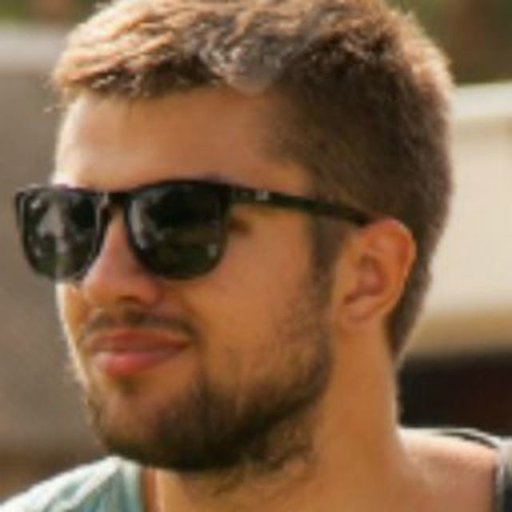

In [242]:
load_image(IMG_PATH)

In [243]:
def init_hyperparams(im):
    W, H = im.size
    n, m = 16, 16
    L = H / n * W / m
    N = n * m * S
    return W, H, n, m, L, N, S

pic = load_image(IMG_PATH)
W, H, n, m, L, N, S = init_hyperparams(pic)
print W, H, L, N, S
# imshow(pic)

512 512 1024 768 3


In [246]:
def encode_pixel(P):
    C_MAX = 255.0
    P = np.array(P)
    return (2.0 * P / C_MAX) - 1.0

def encode_area(im, lu_corner, rb_corner):
    X0, Y0 = lu_corner
    X1, Y1 = rb_corner
    
    def transform(x, y):
        return encode_pixel(im.getpixel((x, y)))
    
    q = []
    for x in range(X0, X1 + 1):
        for y in range(Y0, Y1 + 1):
            q.append(transform(x, y))
    return np.array(q).flatten()

def decode_area(area):
    C_MAX = 255.0
    return np.clip(np.int_(C_MAX * (area + 1.0) / 2.0), 0, 255)

def decode_image(areas):
    if S == 1:
        im_area = np.empty((H, W))
    else:
        im_area = np.empty((H, W, S))
    for i in range(H):
        for j in range(W):
            ii = i / n
            jj = j / m
            idx = ii * (W / m) + jj
            im_area[j][i] = decode_area(areas[idx][0][(i % n) * m + j % m:(i % n) * m + j % m + S])
    return Image.fromarray(im_area.astype('uint8'), mode=MODE)

def transform_random_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return encode_area(im, lu, rb)
    
    while True:
        i = np.random.randint(im.height - n)
        j = np.random.randint(im.width - m)
        X = transform(i, j)
        yield X.reshape(1, len(X))
        

def transform_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return encode_area(im, lu, rb)
    
    for i in range(0, im.height, n):
        for j in range(0, im.width, m):
            X = transform(i, j)
            yield X.reshape(1, len(X))

In [247]:
def get_Z(N, L, p):
    return ((N + L) * p + 2.0) / (N * L)

In [248]:
# im = load_image(IMG_PATH)
# tr = transform_random_image(im, n, m)
# X = next(tr)
# print X.shape
# print X

In [249]:
def glorot_uniform(input_layers, output_layers):
    limit = np.sqrt(6.0 / (input_layers + output_layers))
    return partial(np.random.uniform, low=-limit, high=limit)

class Autoencoder(object):
    def __init__(self, input_layers=1000, lr=1e-2, max_err=1000.0, dynamic_lr=True, z=0.9, w_norm=True):
        self.input_layers = input_layers
        self.mid_layers = int(z * input_layers)
        self.initializer = glorot_uniform(self.input_layers, self.mid_layers)
        self.lr = lr
        self.w_norm = w_norm
        self.max_err = max_err
        self.dynamic_lr = dynamic_lr
        self.build()
        
    def error(self, err):
        return err**2
    
    def build(self):
        self.W1 = self.initializer(size=[self.input_layers, self.mid_layers])
        self.W2 = self.W1.T
    
    def __call__(self, gen, pbar=None):
        err = 0.0
        for inp in gen:
            mid, res = self.forward(inp)
            diff = res - inp
            err += self.error(diff).sum()
            self.backward(inp, mid, diff)
            if pbar:
                pbar.update(1)
        return err
    
    def forward(self, inp):
        mid = self.encode(inp, self.W1)
        return mid, self.decode(mid, self.W2)
    
    def backward(self, inp, mid, err):
        lr = self.lr
        if self.dynamic_lr:
            lr = 1.0 / np.dot(inp, inp.T)**2
        self.W1 -= lr * np.dot(np.dot(inp.T, err), self.W2.T)
        if self.dynamic_lr:
            lr = 1.0 / np.dot(mid, mid.T)**2
        self.W2 -= lr * np.dot(mid.T, err)
        
        if self.w_norm:
            self.W2 /= np.linalg.norm(self.W2, axis=0, keepdims=True)
            self.W1 /= np.linalg.norm(self.W1, axis=1, keepdims=True)

    def encode(self, inp, W1):
        return np.dot(inp, W1)
    
    def decode(self, mid, W2):
        return np.dot(mid, W2)

In [263]:
def try_run(model, epochs, name='', th_err=0.1, viz=True, ax=None, gen=None, progress=True, L=L):
    np.random.seed(SEED)
    errors = []
    if gen is None:
        im = load_image(IMG_PATH)
        gen = transform_image(im, n, m)
    gens = tee(gen, epochs)
    best_results = {
        'W1': None,
        'W2': None,
        'min_err': np.inf,
        'epoch': epochs,
    }

    def run_iters(pbar=None):
        epoch_run = 0
        err = np.inf
        min_err = np.inf
        cur_gen = 0
        while epoch_run < epochs and err > th_err:
            t_gen = gens[cur_gen]
            cur_gen += 1
            errors.append(model(t_gen, pbar))
            if errors[-1] < min_err:
                best_results['min_err'] = errors[-1]
                best_results['W1'] = model.W1
                best_results['W2'] = model.W2
                min_err = errors[-1]
            err = errors[-1]
            epoch_run += 1

        best_results['epoch'] = epoch_run

    if progress:
        with tqdm(total=epochs*L) as pbar:
            run_iters(pbar)
    else:
        run_iters()
    
    if viz:
        epoch = best_results['epoch']
        x = np.arange(epoch)
        idx = np.argmin(errors)
        print("BEST ERROR {} at {}".format(errors[idx], idx))
        
        if ax is None:
            plt.plot(x, np.array(errors))
            plt.title(name)
            plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
            plt.show()
        else:
            ax.plot(x, np.array(errors))
            ax.set_title(name)
            ax.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
    return best_results
    
def viz_encode(model, best_results, path=IMG_PATH):
    W1 = best_results['W1']
    W2 = best_results['W2']
    min_err = best_results['min_err']
    epoch = best_results['epoch']
    
    print 'Showing results for min_err={}. Epoch run: {}'.format(min_err, epoch)
    areas = []
    im = load_image(path)
    for area in transform_image(im, n, m):
        areas.append(model.decode(model.encode(area, W1), W2))
    areas = np.array(areas)
    new_pic = decode_image(areas)
    return new_pic

  0%|          | 15/51200 [00:00<05:49, 146.25it/s]

Running for z=0.1


100%|██████████| 51200/51200 [05:32<00:00, 153.91it/s]


BEST ERROR 5766.86406515 at 49
Showing results for min_err=5766.86406515. Epoch run: 50
(1024, 1, 768)


  0%|          | 7/51200 [00:00<13:29, 63.27it/s]

Running for z=0.366666666667


100%|██████████| 51200/51200 [11:17<00:00, 81.66it/s]


BEST ERROR 1374.18324324 at 49
Showing results for min_err=1374.18324324. Epoch run: 50
(1024, 1, 768)


  0%|          | 4/51200 [00:00<22:27, 37.99it/s]

Running for z=0.633333333333


100%|██████████| 51200/51200 [18:07<00:00, 47.09it/s]


BEST ERROR 718.8516077 at 49
Showing results for min_err=718.8516077. Epoch run: 50
(1024, 1, 768)


  0%|          | 3/51200 [00:00<28:30, 29.93it/s]

Running for z=0.9


100%|██████████| 51200/51200 [26:02<00:00, 32.68it/s]


BEST ERROR 488.79060025 at 49
Showing results for min_err=488.79060025. Epoch run: 50
(1024, 1, 768)


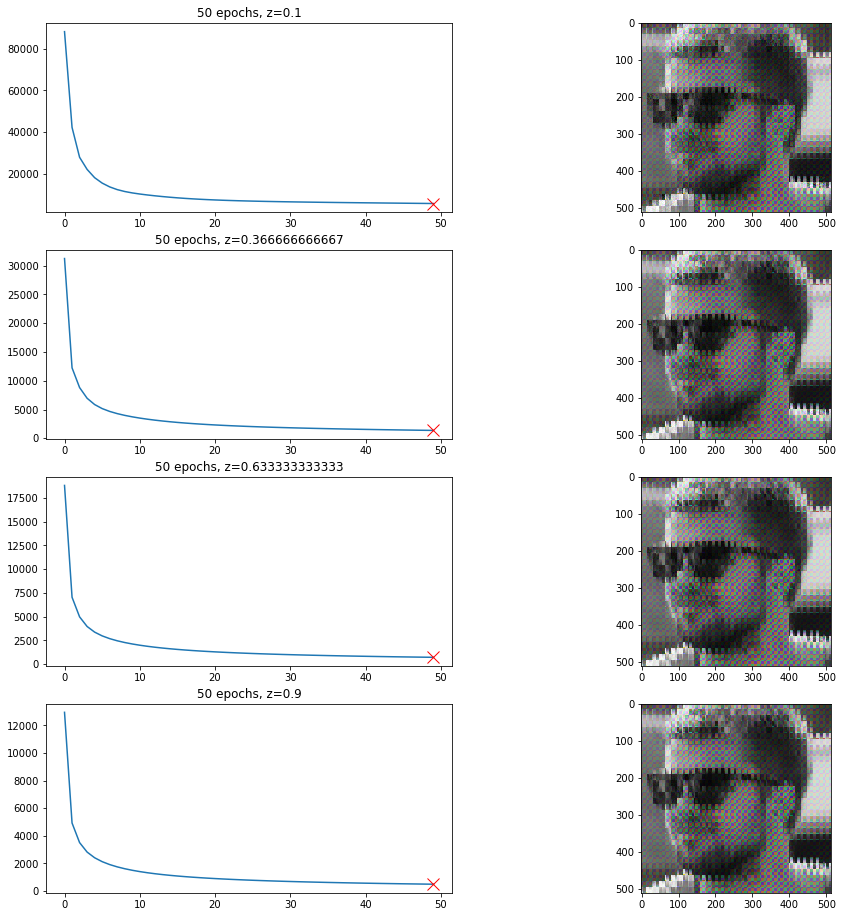

In [145]:
N_z = 4
fig, ax = plt.subplots(N_z, 2, figsize=(16, 16))
for i, z in enumerate(np.linspace(0.1, 0.9, N_z)):
    print 'Running for z={}'.format(z)
    epochs = 50
    model = Autoencoder(input_layers=N, z=z)
    best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, ax=ax[i][0])
    new_pic = viz_encode(model, best_results)
    ax[i][1].imshow(new_pic)

100%|██████████| 51200/51200 [06:43<00:00, 101.12it/s]


BEST ERROR 873.948846041 at 49


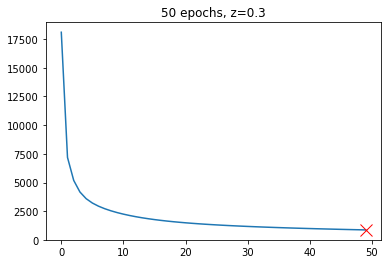

Showing results for min_err=873.948846041. Epoch run: 50


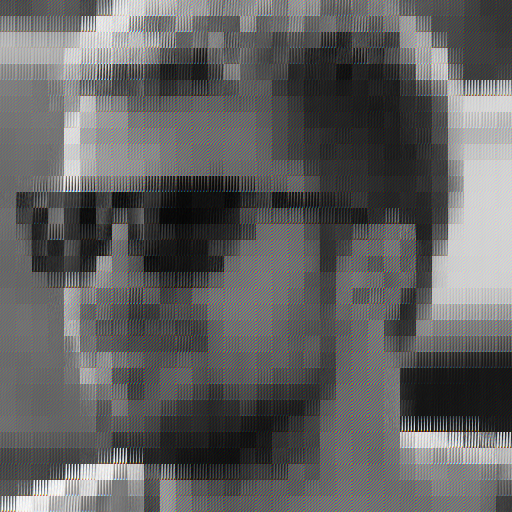

In [251]:
z = 0.3
epochs = 50
model = Autoencoder(input_layers=N, z=z, w_norm=False, dynamic_lr=True)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 51200/51200 [08:01<00:00, 111.94it/s]


BEST ERROR 3597.00682175 at 49


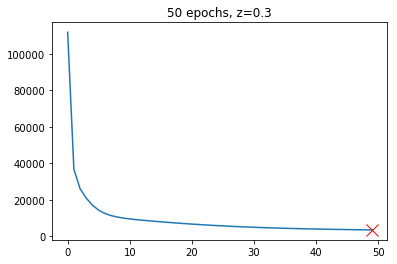

Showing results for min_err=3597.00682175. Epoch run: 50
(1024, 1, 768)


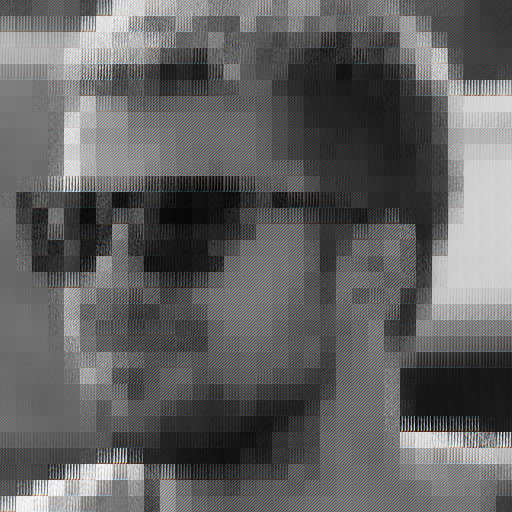

In [149]:
z = 0.3
epochs = 50
model = Autoencoder(input_layers=N, z=z, w_norm=False, dynamic_lr=False, lr=1e-5)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 51200/51200 [08:42<00:00, 97.93it/s] 


BEST ERROR 31533.8086971 at 49


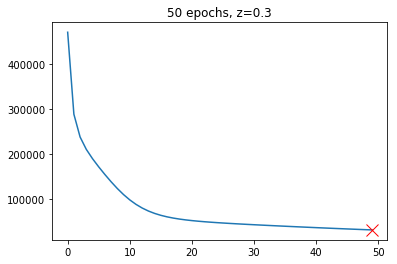

Showing results for min_err=31533.8086971. Epoch run: 50
(1024, 1, 768)


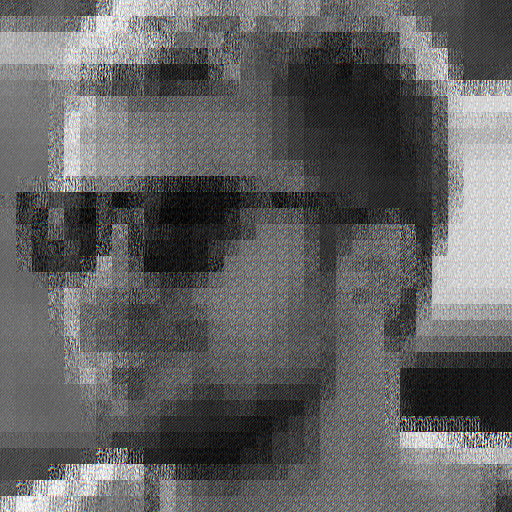

In [154]:
z = 0.3
epochs = 50
model = Autoencoder(input_layers=N, z=z, w_norm=True, dynamic_lr=False, lr=1e-6)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic

  0%|          | 13/51200 [00:00<06:38, 128.61it/s]

Running for lr=1e-07


100%|██████████| 51200/51200 [05:54<00:00, 144.40it/s]


BEST ERROR 286534.178419 at 49
Showing results for min_err=286534.178419. Epoch run: 50
(1024, 1, 768)


  0%|          | 14/51200 [00:00<06:15, 136.18it/s]

Running for lr=2.575e-06


100%|██████████| 51200/51200 [05:28<00:00, 155.81it/s]


BEST ERROR 215280.474623 at 49
Showing results for min_err=215280.474623. Epoch run: 50
(1024, 1, 768)


  0%|          | 13/51200 [00:00<06:37, 128.71it/s]

Running for lr=5.05e-06


100%|██████████| 51200/51200 [05:33<00:00, 163.56it/s]


BEST ERROR 211165.189133 at 49
Showing results for min_err=211165.189133. Epoch run: 50
(1024, 1, 768)


  0%|          | 15/51200 [00:00<05:44, 148.62it/s]

Running for lr=7.525e-06


100%|██████████| 51200/51200 [05:37<00:00, 151.76it/s]


BEST ERROR 209363.048804 at 49
Showing results for min_err=209363.048804. Epoch run: 50
(1024, 1, 768)


  0%|          | 14/51200 [00:00<06:21, 134.12it/s]

Running for lr=1e-05


100%|██████████| 51200/51200 [05:18<00:00, 160.80it/s]


BEST ERROR 208325.881616 at 49
Showing results for min_err=208325.881616. Epoch run: 50
(1024, 1, 768)


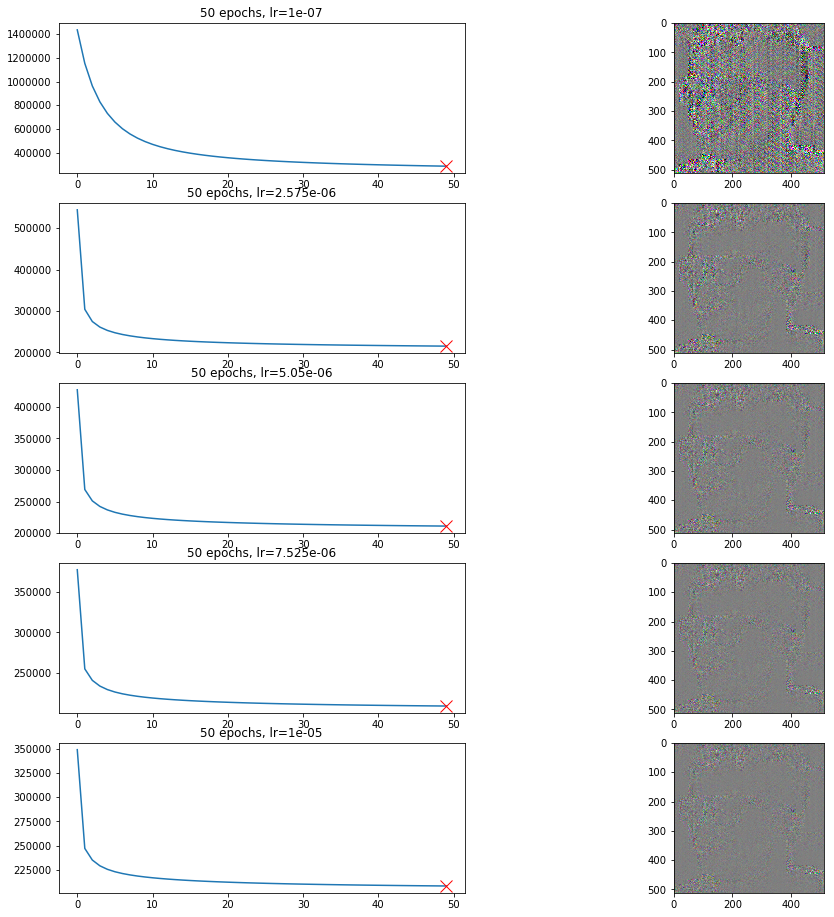

In [155]:
z = 0.15
lrs = np.linspace(1e-7, 1e-5, 5)
fig, ax = plt.subplots(lrs.shape[0], 2, figsize=(16, 16))
for i, lr in enumerate(lrs):
    print 'Running for lr={}'.format(lr)
    epochs = 50
    model = Autoencoder(input_layers=N, z=z, dynamic_lr=False, w_norm=True, lr=lr)
    best_results = try_run(model, epochs, '{} epochs, lr={}'.format(epochs, lr), th_err=100.0, ax=ax[i][0])
    new_pic = viz_encode(model, best_results)
    ax[i][1].imshow(new_pic)

100%|██████████| 163840/163840 [12:58<00:00, 210.43it/s]


BEST ERROR 63630.5974233 at 39


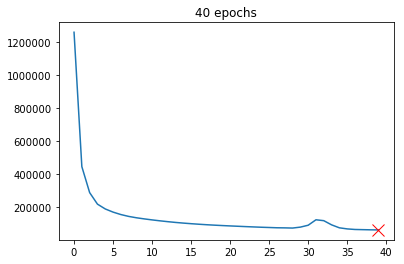

Showing results for min_err=63630.5974233. Epoch run: 40


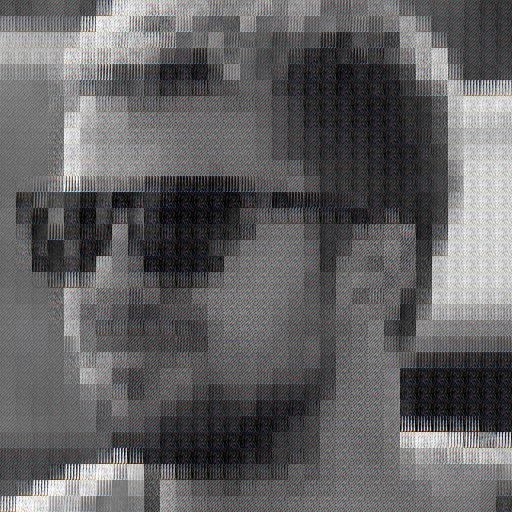

In [271]:
imgs = next(walk('./pics/'))[2]
epochs = 40
T = len(imgs)
model = Autoencoder(input_layers=N, z=0.1)

def get_multi_gen():
    for i in range(T):
        path = './pics/{}'.format(imgs[i])
        im = load_image(path)
        for part in transform_image(im, n, m):
            yield part

best_results = try_run(model, epochs, '{} epochs'.format(epochs), gen=get_multi_gen(), th_err=150.0, L=L*T)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 409600/409600 [31:16<00:00, 218.29it/s] 


BEST ERROR 45472.6175492 at 99


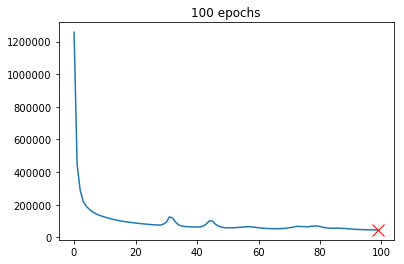

Showing results for min_err=45472.6175492. Epoch run: 100


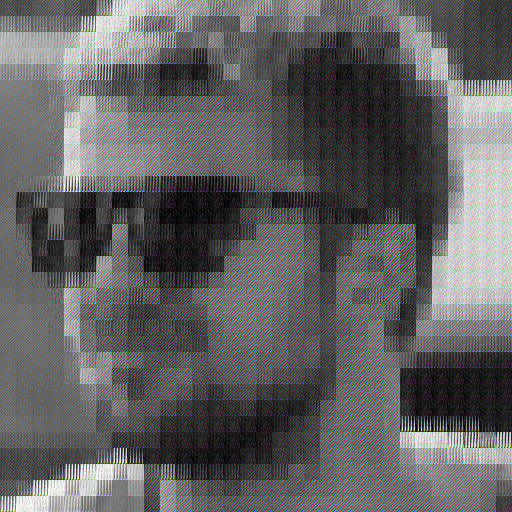

In [274]:
imgs = next(walk('./pics/'))[2]
epochs = 100
T = len(imgs)
model = Autoencoder(input_layers=N, z=0.1)

def get_multi_gen():
    for i in range(T):
        path = './pics/{}'.format(imgs[i])
        im = load_image(path)
        for part in transform_image(im, n, m):
            yield part

best_results = try_run(model, epochs, '{} epochs'.format(epochs), gen=get_multi_gen(), th_err=150.0, L=L*T)
new_pic = viz_encode(model, best_results)
new_pic

In [275]:
next(walk('./pics/'))[2]

['cornell_box_04.jpg', 'Haydn-Jones.jpg', 'NettyScribble.jpg', 'baboon.jpg']

In [ ]:
3) glorot function from?

100%|██████████| 102400/102400 [28:08<00:00, 60.64it/s]


BEST ERROR 590.039487641 at 99


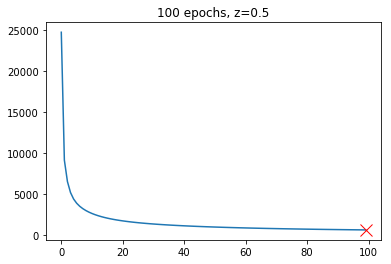

Showing results for min_err=590.039487641. Epoch run: 100


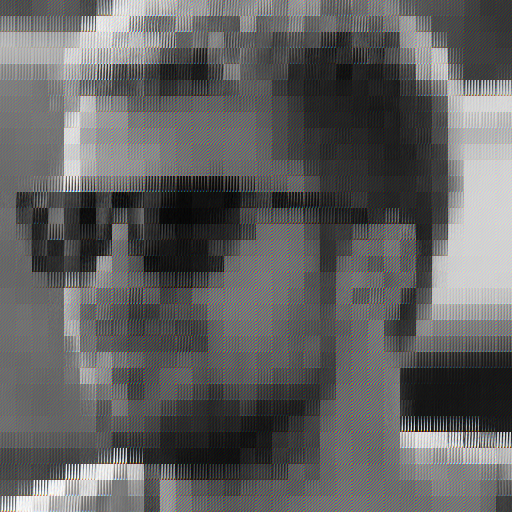

In [277]:
z = 0.5
epochs = 100
model = Autoencoder(input_layers=N, z=z)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic